In [1]:
import io
import numpy as np

from PIL import Image, ImageDraw as D

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import argparse
import math
import random
import shutil
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.transforms

from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

from compressai.datasets import ImageFolder
from compressai.zoo import mbt2018

from piq import psnr

import os

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [2]:
image_filename = 'c0564'
basedir = '/Users/clemens/vsc-data/'

image_original = Image.open(basedir + 'test_images/' + image_filename + '.png').convert('RGB')

image_supersampled = Image.open(basedir + 'bicubic_supersampled/' + image_filename + '_x2_SR.png').convert('RGB')

image = {
    'q4_mse_fullres': Image.open(basedir + 'mbt2018_q4_mse_fullres/' + image_filename + '.png').convert('RGB'),
    'q4_msssim_fullres': Image.open(basedir + 'mbt2018_q4_msssim_fullres/' + image_filename + '.png').convert('RGB'),
    'q4_mse_x2res': Image.open(basedir + 'mbt2018_q4_mse_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    'q4_msssim_x2res': Image.open(basedir + 'mbt2018_q4_msssim_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    'q6_mse_fullres': Image.open(basedir + 'mbt2018_q6_mse_fullres/' + image_filename + '.png').convert('RGB'),
    'q6_msssim_fullres': Image.open(basedir + 'mbt2018_q6_msssim_fullres/' + image_filename + '.png').convert('RGB'),
    'q6_mse_x2res': Image.open(basedir + 'mbt2018_q6_mse_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    'q6_msssim_x2res': Image.open(basedir + 'mbt2018_q6_msssim_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    'q8_mse_fullres': Image.open(basedir + 'mbt2018_q8_mse_fullres/' + image_filename + '.png').convert('RGB'),
    'q8_msssim_fullres': Image.open(basedir + 'mbt2018_q8_msssim_fullres/' + image_filename + '.png').convert('RGB'),
    'q8_mse_x2res': Image.open(basedir + 'mbt2018_q8_mse_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB'),
    'q8_msssim_x2res': Image.open(basedir + 'mbt2018_q8_msssim_x2res_supersampled/' + image_filename + '_x2_SR.png').convert('RGB')
}

In [3]:
pilToTensor = transforms.Compose([transforms.PILToTensor()])

upscaled = '/Users/clemens/vsc-data/bicubic_supersampled/' + image_filename + '_x2_SR.png'
upscaledImg = pilToTensor(Image.open(upscaled).convert('RGB')).unsqueeze(0) / 255.0
original = '/Users/clemens/vsc-data/test_images/' + image_filename + '.png'
originalImg = pilToTensor(Image.open(original).convert('RGB')).unsqueeze(0) / 255.0
psnr_ss = psnr(upscaledImg, originalImg, data_range=1.0).item()
msssim_ss = ms_ssim(upscaledImg, originalImg, data_range=1.0, size_average=True).item()

In [4]:
device = "cpu"
model = "mbt2018"
suffix = "_500ep"

directory = '/Users/clemens/vsc-data/test_images'
x2dir = '/Users/clemens/vsc-data/test_images_x2'


bpp = {
#    'q4mse': 0,
#    'q4msssim': 0,
#    'q6mse': 0,
#    'q6msssim': 0,
#    'q8mse': 0,
#    'q8msssim': 0
}
psnr_results = {
#    'q4mse': 0,
#    'q4msssim': 0,
#    'q6mse': 0,
#    'q6msssim': 0,
#    'q8mse': 0,
#    'q8msssim': 0
}
msssim_results = {
    'q4mse': 0,
    'q4msssim': 0,
    'q6mse': 0,
    'q6msssim': 0,
    'q8mse': 0,
    'q8msssim': 0
}

def pad (x):
    h, w = x.size(2), x.size(3)
    p = 64  # maximum 6 strides of 2
    new_h = (h + p - 1) // p * p
    new_w = (w + p - 1) // p * p
    padding_left = (new_w - w) // 2
    padding_right = new_w - w - padding_left
    padding_top = (new_h - h) // 2
    padding_bottom = new_h - h - padding_top
    return F.pad(
        x,
        (padding_left, padding_right, padding_top, padding_bottom),
        mode="constant",
        value=0,
    )

for quality in [4, 6, 8]:
    for metric in ['mse', 'msssim']:
        for res in ['fullres', 'x2res']:
            net = mbt2018(quality=quality, pretrained=False).eval().to(device)
            file = "/Users/clemens/vsc-data/mbt/" + model + "_q" + str(quality) + "_" + metric + suffix + ".pth.tar"
            print(file)
            checkpoint = torch.load(file, map_location=device)
            net.load_state_dict(checkpoint["state_dict"])
            print("Actual epochs:" + str(checkpoint["epoch"] + 1))

            filename = os.path.join(directory if res == 'fullres' else x2dir, image_filename + ('.png' if res == 'fullres' else 'x2.png'))
            if filename.endswith(".png"):
                print(filename)
                img = Image.open(filename).convert('RGB')
                x = transforms.ToTensor()(img).unsqueeze(0).to(device)
                x = pad(x)
                
                with torch.no_grad():
                    out_net = net.forward(x)
                out_net['x_hat'].clamp_(0, 1)
                width, height = img.size
                num_pixels = 3 * width * height
                bpp["q"+str(quality)+metric+'_'+res] = sum(
                    (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
                    for likelihoods in out_net["likelihoods"].values()
                ).item() / (4 if res == 'x2res' else 1)
                if (res == 'fullres'):
                    crop_x = int((out_net["x_hat"].size()[3] - width) / 2)
                    crop_y = int((out_net["x_hat"].size()[2] - height) / 2)
                    psnr_results["q"+str(quality)+metric+'_'+res] = psnr(out_net["x_hat"][:, :, crop_y:(height+crop_y), crop_x:(width+crop_x)], pilToTensor(img).unsqueeze(0) / 255.0, data_range=1.0).item()
                    msssim_results["q"+str(quality)+metric+'_'+res] = ms_ssim(out_net["x_hat"][:, :, crop_y:(height+crop_y), crop_x:(width+crop_x)], pilToTensor(img).unsqueeze(0) / 255.0, data_range=1.0, size_average=True).item()
                else:
                    upscaled = '/Users/clemens/vsc-data/mbt2018_q' + str(quality) + '_' + metric + '_x2res_supersampled/' + image_filename + '_x2_SR.png'
                    upscaledImg = pilToTensor(Image.open(upscaled).convert('RGB')).unsqueeze(0) / 255.0
                    original = '/Users/clemens/vsc-data/test_images/' + image_filename + '.png'
                    originalImg = pilToTensor(Image.open(original).convert('RGB')).unsqueeze(0) / 255.0
                    psnr_results["q"+str(quality)+metric+'_'+res] = psnr(upscaledImg, originalImg, data_range=1.0).item()
                    msssim_results["q"+str(quality)+metric+'_'+res] = ms_ssim(upscaledImg, originalImg, data_range=1.0, size_average=True).item()

/Users/clemens/vsc-data/mbt/mbt2018_q4_mse_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0564.png
/Users/clemens/vsc-data/mbt/mbt2018_q4_mse_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images_x2/c0564x2.png
/Users/clemens/vsc-data/mbt/mbt2018_q4_msssim_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0564.png
/Users/clemens/vsc-data/mbt/mbt2018_q4_msssim_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images_x2/c0564x2.png
/Users/clemens/vsc-data/mbt/mbt2018_q6_mse_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0564.png
/Users/clemens/vsc-data/mbt/mbt2018_q6_mse_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images_x2/c0564x2.png
/Users/clemens/vsc-data/mbt/mbt2018_q6_msssim_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images/c0564.png
/Users/clemens/vsc-data/mbt/mbt2018_q6_msssim_500ep.pth.tar
Actual epochs:500
/Users/clemens/vsc-data/test_images_x2/c0564x2.png


In [5]:
print(bpp)
print(psnr_results)
print(msssim_results)

{'q4mse_fullres': 0.0664869174361229, 'q4mse_x2res': 0.02143939770758152, 'q4msssim_fullres': 0.08505531400442123, 'q4msssim_x2res': 0.024761248379945755, 'q6mse_fullres': 0.14486585557460785, 'q6mse_x2res': 0.05107232183218002, 'q6msssim_fullres': 0.1600700467824936, 'q6msssim_x2res': 0.04955458641052246, 'q8mse_fullres': 0.2981182634830475, 'q8mse_x2res': 0.10878190398216248, 'q8msssim_fullres': 0.2904316484928131, 'q8msssim_x2res': 0.09419441223144531}
{'q4mse_fullres': 36.319786071777344, 'q4mse_x2res': 30.913818359375, 'q4msssim_fullres': 35.93061065673828, 'q4msssim_x2res': 30.603225708007812, 'q6mse_fullres': 39.58647918701172, 'q6mse_x2res': 31.345579147338867, 'q6msssim_fullres': 38.211830139160156, 'q6msssim_x2res': 31.146350860595703, 'q8mse_fullres': 43.744972229003906, 'q8mse_x2res': 31.116287231445312, 'q8msssim_fullres': 41.850528717041016, 'q8msssim_x2res': 31.31058120727539}
{'q4mse': 0, 'q4msssim': 0, 'q6mse': 0, 'q6msssim': 0, 'q8mse': 0, 'q8msssim': 0, 'q4mse_fullre

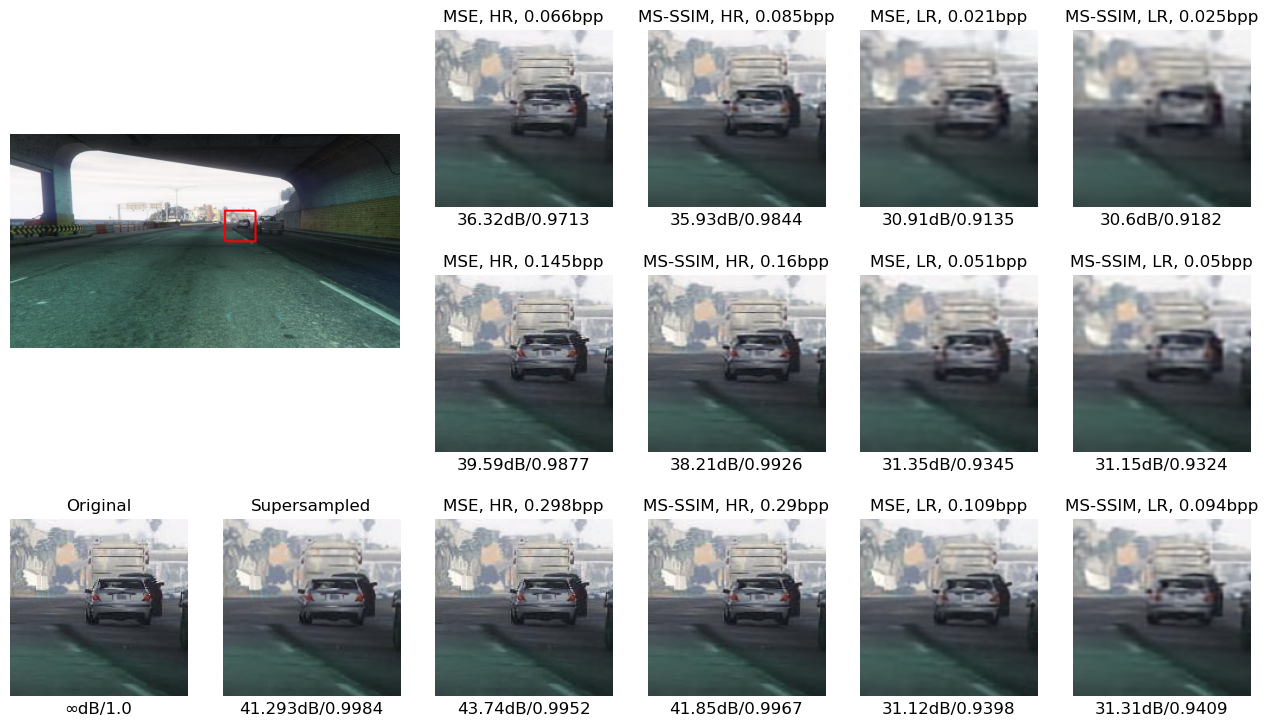

In [8]:
%matplotlib inline
#fix, axes = plt.subplots(2, 7, figsize=(16, 12))
image_original = Image.open(basedir + 'test_images/' + image_filename + '.png').convert('RGB')

fig = plt.figure(figsize=(16, 9))
gs = GridSpec(3,6)
x1 = 1050
y1 = 375
x2 = 1200
y2 = 525
crop = (x1, y1, x2, y2)

#print(axes.shape)
#for ax in axes:
#    for a in ax:
#        a.axis('off')

#original_span = axes[1, 2].get_gridspec()
rect = fig.add_subplot(gs[2,0])
rect.imshow(image_original.crop(crop))
rect.title.set_text('Original')
rect.text(0.5,-0.1, '\u221EdB/1.0', size=12, ha="center", transform=rect.transAxes)
rect.axis('off')

draw=D.Draw(image_original)
width = 10
cor = crop
for i in range(width):
    draw.rectangle(cor, outline="red")   
    cor = (cor[0]+1,cor[1]+1, cor[2]+1,cor[3]+1)

main = fig.add_subplot(gs[0:2,0:2])
main.imshow(image_original)
main.axis('off')
#main.title.set_text('Original')

rect = fig.add_subplot(gs[2,1])
rect.imshow(image_supersampled.crop(crop))
rect.title.set_text('Supersampled')
rect.text(0.5,-0.1, str(round(psnr_ss, 3)) + 'dB/' + str(round(msssim_ss, 4)), size=12, ha="center", transform=rect.transAxes)
rect.axis('off')

for quality in [4,6,8]:
    for metric in ['mse', 'msssim']:
        for res in ['fullres', 'x2res']:
            y_axis = (0 if metric == 'mse' else 1) + (0 if res == 'fullres' else 2) + 2
            rect = fig.add_subplot(gs[int(quality/2)-2,y_axis])
            rect.imshow(image['q' + str(quality) + '_' + metric + '_' + res].crop(crop))
            rect.title.set_text(
                ('MSE' if metric == 'mse' else 'MS-SSIM') + ', ' +
                ('HR' if res == 'fullres' else 'LR') + ', ' +
                (str(round(bpp["q"+str(quality)+metric+'_'+res],3)) + 'bpp')
            )
            rect.text(0.5,-0.1, str(round(psnr_results["q"+str(quality)+metric+'_'+res],2)) + 'dB/' + str(round(msssim_results["q"+str(quality)+metric+'_'+res],4)), size=12, ha="center", 
         transform=rect.transAxes)
            rect.axis('off')

#rect = fig.add_subplot(gs[0,2+grid_offset])
#rect.imshow(image_q4_mse_fullres.crop(crop))
#rect.title.set_text('MSE, HR, q4 BPP')
#rect.axis('off')
#
#rect = fig.add_subplot(gs[0,3+grid_offset])
#rect.imshow(image_q4_msssim_fullres.crop(crop))
#rect.title.set_text('MSSSIM, HR, q4 BPP')
#rect.axis('off')
#
#rect = fig.add_subplot(gs[0,4+grid_offset])
#rect.imshow(image_q4_mse_x2res.crop(crop))
#rect.title.set_text('MSE, LR, q4 BPP')
#rect.axis('off')
#
#rect = fig.add_subplot(gs[0,5+grid_offset])
#rect.imshow(image_q4_msssim_x2res.crop(crop))
#rect.title.set_text('MSSSIM, LR, q4 BPP')
#rect.axis('off')
#
#
#
#rect = fig.add_subplot(gs[1,2+grid_offset])
#rect.imshow(image_q6_mse_fullres.crop(crop))
#rect.title.set_text('MSE, HR, q6 BPP')
#rect.axis('off')
#
#rect = fig.add_subplot(gs[1,3+grid_offset])
#rect.imshow(image_q6_msssim_fullres.crop(crop))
#rect.title.set_text('MSSSIM, HR, q6 BPP')
#rect.axis('off')
#
#rect = fig.add_subplot(gs[1,4+grid_offset])
#rect.imshow(image_q6_mse_x2res.crop(crop))
#rect.title.set_text('MSE, LR, q6 BPP')
#rect.axis('off')
#
#rect = fig.add_subplot(gs[1,5+grid_offset])
#rect.imshow(image_q6_msssim_x2res.crop(crop))
#rect.title.set_text('MSSSIM, LR, q6 BPP')
#rect.axis('off')
#
#
#
#rect = fig.add_subplot(gs[2,2+grid_offset])
#rect.imshow(image_q8_mse_fullres.crop(crop))
#rect.title.set_text('MSE, HR, q8 BPP')
#rect.axis('off')
#
#rect = fig.add_subplot(gs[2,3+grid_offset])
#rect.imshow(image_q8_msssim_fullres.crop(crop))
#rect.title.set_text('MSSSIM, HR, q8 BPP')
#rect.axis('off')
#
#rect = fig.add_subplot(gs[2,4+grid_offset])
#rect.imshow(image_q8_mse_x2res.crop(crop))
#rect.title.set_text('MSE, LR, q8 BPP')
#rect.axis('off')
#
#rect = fig.add_subplot(gs[2,5+grid_offset])
#rect.imshow(image_q8_msssim_x2res.crop(crop))
#rect.title.set_text('MSSSIM, LR, q8 BPP')
#rect.axis('off')


plt.savefig('/Users/clemens/Documents/Bachelor Thesis/ba-thesis/graphics/sample-image-2-supersamplings.pdf', pad_inches=-1)